# ロジスティック回帰


学習用データからパラメータを推定。回帰という名前だが、『識別』する（分類する）手法である


まず二クラス分類問題で考えることにする。

線形識別関数だと識別境界から離れるに従い（圧倒的にどちらかの分類になる場合）値がどんどん大きくなってしまう。
＞＞関数値を0~1の間に収められるようにしようとした。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame,Series 
import math

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['label'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


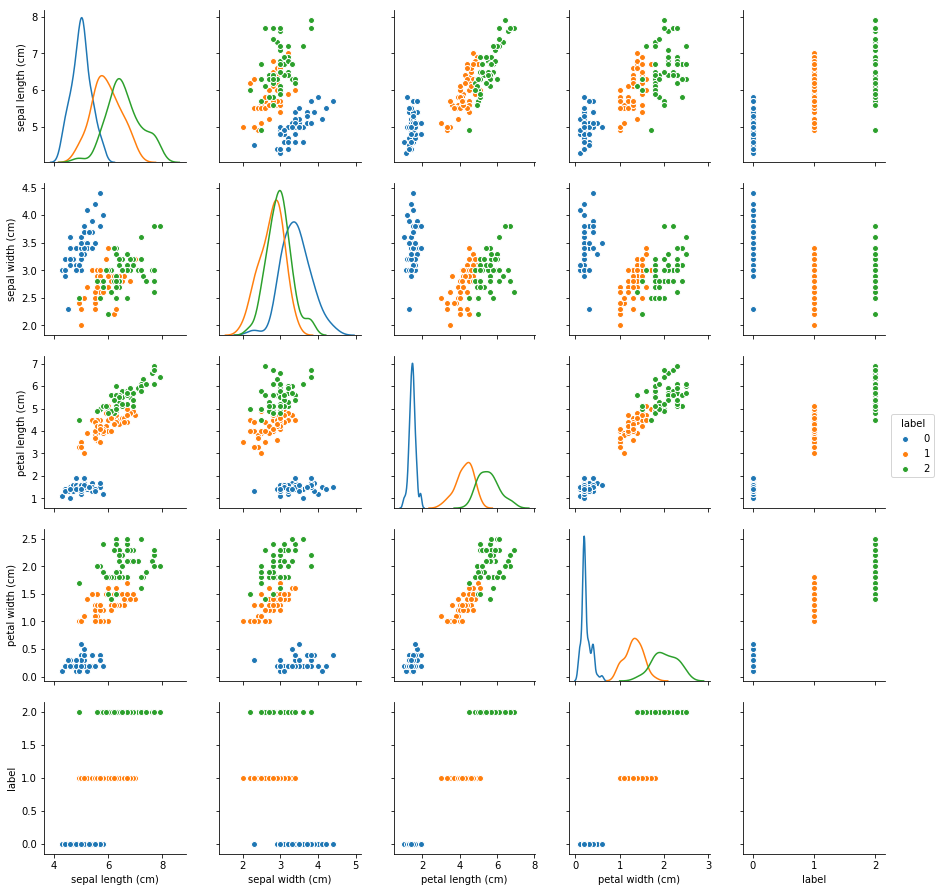

In [3]:
sns.pairplot(data = iris_df,hue = "label",diag_kind = "kde")

In [4]:
#トレーニング用のデータを作成する（のちにテスト用とトレーニング用に分割する。）

iris_data = iris_df[iris_df["label"].isin([1,2])].drop("label",axis = 1) #１と２のみのデータに直した
iris_target = DataFrame(iris.target)[DataFrame(iris.target)[0].isin([1,2])]

#labelのデータを1,2から0,1に直す。
iris_target[0] = iris_target[0] - 1

#DattaFrame -> numpy.array
iris_data = np.array(iris_data)
iris_target = np.array(iris_target)

# ランダムなインデックス作成
index = np.arange(len(iris_data))
np.random.shuffle(index)
 
# 学習データは前半70個
iris_train_data =  iris_data[index[:70]]
iris_train_target = iris_target[index[:70]]
 
# テストデータは後半30個
iris_test_data = iris_data[index[70:]]
iris_test_target = iris_target[index[70:]]

In [5]:
print(iris_train_data)
print(iris_test_data)
print(iris_train_target)
print(iris_test_target)

[[6.1 3.  4.6 1.4]
 [5.6 3.  4.5 1.5]
 [6.5 3.  5.2 2. ]
 [6.3 2.7 4.9 1.8]
 [7.7 3.  6.1 2.3]
 [5.6 2.9 3.6 1.3]
 [6.5 2.8 4.6 1.5]
 [6.7 3.3 5.7 2.5]
 [7.7 2.8 6.7 2. ]
 [6.5 3.2 5.1 2. ]
 [7.7 3.8 6.7 2.2]
 [6.9 3.1 5.4 2.1]
 [6.2 3.4 5.4 2.3]
 [5.6 2.8 4.9 2. ]
 [6.1 3.  4.9 1.8]
 [6.2 2.8 4.8 1.8]
 [5.9 3.2 4.8 1.8]
 [6.5 3.  5.8 2.2]
 [7.4 2.8 6.1 1.9]
 [6.7 3.1 5.6 2.4]
 [5.8 2.7 3.9 1.2]
 [5.4 3.  4.5 1.5]
 [5.7 2.8 4.1 1.3]
 [6.7 3.  5.2 2.3]
 [6.3 2.3 4.4 1.3]
 [5.8 2.7 5.1 1.9]
 [5.  2.3 3.3 1. ]
 [6.  2.9 4.5 1.5]
 [6.3 3.4 5.6 2.4]
 [5.8 2.7 4.1 1. ]
 [6.4 2.7 5.3 1.9]
 [5.5 2.5 4.  1.3]
 [5.7 3.  4.2 1.2]
 [7.  3.2 4.7 1.4]
 [6.  2.7 5.1 1.6]
 [4.9 2.5 4.5 1.7]
 [7.9 3.8 6.4 2. ]
 [6.7 3.1 4.7 1.5]
 [5.6 2.5 3.9 1.1]
 [7.2 3.6 6.1 2.5]
 [6.1 2.9 4.7 1.4]
 [6.7 3.3 5.7 2.1]
 [6.1 2.6 5.6 1.4]
 [6.6 2.9 4.6 1.3]
 [7.7 2.6 6.9 2.3]
 [6.4 2.9 4.3 1.3]
 [6.  2.2 5.  1.5]
 [6.5 3.  5.5 1.8]
 [5.  2.  3.5 1. ]
 [6.9 3.1 4.9 1.5]
 [5.7 2.5 5.  2. ]
 [5.5 2.4 3.7 1. ]
 [5.9 3.  5.

In [6]:
#正規化

ave_train = [sum(iris_train_data[:,i])/len(iris_train_data[:,i]) for i in range(iris_train_data.shape[1])]
std_train = [math.sqrt(sum(iris_train_data[:,i]**2)/len(iris_train_data[:,i])-ave_train[i]) for i in range (iris_train_data.shape[1])]

#ave_test = [sum(iris_test_data[:,i])/len(iris_test_data[:,i]) for i in range(iris_test_data.shape[1])]
#std_test = [math.sqrt(sum(iris_test_data[:,i]**2)/len(iris_test_data[:,i])-ave_test[i]) for i in range (iris_test_data.shape[1])]

#テストデータとトレーニングデータの平均と分散を算出

for i in range (len(iris_train_data)):
    for j in range (len(iris_train_data[i])):
        iris_train_data[i][j] = (iris_train_data[i][j] - ave_train[j]) / std_train[j]

for i in range (len(iris_test_data)):
    for j in range (len(iris_test_data[i])):
        iris_test_data[i][j] = (iris_test_data[i][j] - ave_train[j]) / std_train[j]

#テストデータとトレーニングデータを正規化

In [7]:
# 定数項をweightのwの中に入れてしまうためにtrain_dataに全てのrowで値が１となるcolumnを作る。
iris_train_data1 = np.insert(iris_train_data,iris_train_data.shape[1],1,axis = 1)

#test_dataでも同じことをする
iris_test_data1 = np.insert(iris_test_data,iris_test_data.shape[1],1,axis = 1)

print(iris_train_data1)
print(iris_test_data1)

[[-0.03746022  0.04030145 -0.08398885 -0.26770303  1.        ]
 [-0.12315355  0.04030145 -0.10609118 -0.18367069  1.        ]
 [ 0.03109443  0.04030145  0.04862512  0.23649102  1.        ]
 [-0.00318289 -0.08601654 -0.01768186  0.06842634  1.        ]
 [ 0.23675841  0.04030145  0.24754609  0.48858804  1.        ]
 [-0.12315355 -0.00180454 -0.30501215 -0.35173537  1.        ]
 [ 0.03109443 -0.04391054 -0.08398885 -0.18367069  1.        ]
 [ 0.06537176  0.16661944  0.15913677  0.65665273  1.        ]
 [ 0.23675841 -0.04391054  0.38016007  0.23649102  1.        ]
 [ 0.03109443  0.12451345  0.0265228   0.23649102  1.        ]
 [ 0.23675841  0.37714942  0.38016007  0.4045557   1.        ]
 [ 0.09964909  0.08240745  0.09282978  0.32052336  1.        ]
 [-0.02032156  0.20872544  0.09282978  0.48858804  1.        ]
 [-0.12315355 -0.04391054 -0.01768186  0.23649102  1.        ]
 [-0.03746022  0.04030145 -0.01768186  0.06842634  1.        ]
 [-0.02032156 -0.04391054 -0.03978419  0.06842634  1.  

In [8]:
#パラメータ最尤推定が解析的には不可能なので、最急降下法（勾配の一番急な方向に向かってくだって行って傾き０のところまで到達する）をやってみる。
#この関数では負の対数尤度関数のwでの微分を求めている。
def grad(x,t,w):  #xは学習用データの学習させる部分（分類する先のクラスのデータを除いたもの）（m(データ数)*n)、tはtターゲットのデータ(m次)、wはパラメーター(n次）
    grad = np.zeros(len(x[0]))
    for i in range (0,len(x)):
        y_hat = 1/(1 + math.exp(-np.dot(w,x[i])))
        error = y_hat - t[i]   #error : schalar
        grad = grad + error * x[i]
    return grad 

最急降下法についての不安

学習率がよくわからない（どの程度に設定すればいいのか）
初期値の設定の仕方がどうすればいいのか見当がつかない。
＞＞とりあえず初期値は0,学習率が1となるようにした。


最急降下法以外にもニュートンラフソン法などという別の方法もあるらしい。

In [9]:
#最急降下法を実装
def grad_descent(x,t,w0,eta,times):  #初期値と学習率、更新回数は引数として取ることとする。
    w = w0
    i = 0
    while i <= times :  #何かしらの条件を指定。最適なやり方は時と場合によって異なる
        
        w = w - eta * grad(x,t,w)   #パラメーターの値を更新している。
        i = i + 1
        eta = eta * 0.9  #学習率は回を追うごとに小さくするようにしている
    return w


In [10]:


#初期値、学習率、更新回数の設定
w0 = [0,0,0,0,0]
eta = 1
times = 6
w = grad_descent(iris_train_data1,iris_train_target,w0,eta,times)

#result（予測値）を生成    
result = np.zeros(len(iris_test_data1))
for i in range (len(iris_test_data1)):
    y_hat = 1/(1 + math.exp(-np.dot(iris_test_data1[i] , w)))
    if y_hat>0.5:
        result[i] = 1      
    

In [11]:
#評価する
point = 0
for i,j in zip(iris_test_target,result):
    if i == j:
        point = point + 1

accuracy = point/len(result)
print("accuracy:" , accuracy)

accuracy: 0.9666666666666667


現状でもaccuracyはかなり高いと言えるが、非線形の場合への応用として、学習用データを非線形関数に代入したものでの学習なども行なってみる。

非線形変換といっても難しい話ではなく、規定として非線形な関数を導入してやればいいだけのことである。導入の仕方は根拠に基づいた方が望ましい、と思う。どうしても根拠に基づいたものがなければ、多変数関数のテイラー展開の考え方を元にして、一次の項だけでなく二次の項を追加するというのも手か。(完全に自分の考えですが。)


In [13]:
#トレーニング用のデータを作成する（のちにテスト用とトレーニング用に分割する。）

iris_data = iris_df[iris_df["label"].isin([1,2])].drop("label",axis = 1) #１と２のみのデータに直した
iris_target = DataFrame(iris.target)[DataFrame(iris.target)[0].isin([1,2])]

#labelのデータを1,2から0,1に直す。
iris_target[0] = iris_target[0] - 1

#DattaFrame -> numpy.array
iris_data = np.array(iris_data)
iris_target = np.array(iris_target)

#例えば各々の行のデータの二乗の項をデータとして加えたいときはこうなる。他にも非線形行の加え方はいろいろある。
iris_2dim_data = np.concatenate([iris_data,iris_data*iris_data,
                (iris_data[:,0]*iris_data[:,1]).reshape(100,1),(iris_data[:,0]*iris_data[:,2]).reshape(100,1),
                (iris_data[:,0]*iris_data[:,3]).reshape(100,1),(iris_data[:,1]*iris_data[:,2]).reshape(100,1),
                (iris_data[:,1]*iris_data[:,3]).reshape(100,1),(iris_data[:,2]*iris_data[:,3]).reshape(100,1)],axis =1)

In [14]:
len(iris_2dim_data[0])

14

In [15]:
# ランダムなインデックス作成
index = np.arange(len(iris_data))
np.random.shuffle(index)
 
# 学習データは前半70個
iris_train_data =  iris_2dim_data[index[:70]]
iris_train_target = iris_target[index[:70]]
 
# テストデータは後半30個
iris_test_data = iris_2dim_data[index[70:]]
iris_test_target = iris_target[index[70:]]

In [16]:
#正規化

ave_train = [sum(iris_train_data[:,i])/len(iris_train_data[:,i]) for i in range(iris_train_data.shape[1])]
std_train = [math.sqrt(sum(iris_train_data[:,i]**2)/len(iris_train_data[:,i])-ave_train[i]) for i in range (iris_train_data.shape[1])]

#ave_test = [sum(iris_test_data[:,i])/len(iris_test_data[:,i]) for i in range(iris_test_data.shape[1])]
#std_test = [math.sqrt(sum(iris_test_data[:,i]**2)/len(iris_test_data[:,i])-ave_test[i]) for i in range (iris_test_data.shape[1])]

#テストデータとトレーニングデータの平均と分散を算出

for i in range (len(iris_train_data)):
    for j in range (len(iris_train_data[i])):
        iris_train_data[i][j] = (iris_train_data[i][j] - ave_train[j]) / std_train[j]

for i in range (len(iris_test_data)):
    for j in range (len(iris_test_data[i])):
        iris_test_data[i][j] = (iris_test_data[i][j] - ave_train[j]) / std_train[j]

#テストデータとトレーニングデータを正規化

In [17]:
# 定数項をweightのwの中に入れてしまうためにtrain_dataに全てのrowで値が１となるcolumnを作る。
iris_train_data1 = np.insert(iris_train_data,iris_train_data.shape[1],1,axis = 1)

#test_dataでも同じことをする
iris_test_data1 = np.insert(iris_test_data,iris_test_data.shape[1],1,axis = 1)



In [18]:
#初期値、学習率、更新回数の設定
w0 = [0 for i in range(len(iris_train_data1[0]))]
eta = 1
times = 100
w = grad_descent(iris_train_data1,iris_train_target,w0,eta,times)

#result（予測値）を生成    
result = np.zeros(len(iris_test_data1))
for i in range (len(iris_test_data1)):
    y_hat = 1/(1 + math.exp(-np.dot(iris_test_data1[i] , w)))
    if y_hat>0.5:
        result[i] = 1 

In [19]:
#評価する
point = 0
for i,j in zip(iris_test_target,result):
    if i == j:
        point = point + 1

accuracy = point/len(result)
print("accuracy:" , accuracy)

accuracy: 0.8666666666666667


###### 実装の時に役立ったやつ
https://dev.classmethod.jp/machine-learning/logistic-regression-impl/
    
使ってはないけど実装に役立ちそうなやつ
http://blog.brains-tech.co.jp/entry/2016/04/04/105718


###### 仕組みを割と教えてくれているやつ
https://qiita.com/nanairoGlasses/items/6bf747734bac2a509628
    
http://gihyo.jp/dev/serial/01/machine-learning/0020
    

###### 個人的にはネットの資料ではこれはわかりやすかった。
http://tkengo.github.io/blog/2016/06/04/yaruo-machine-learning5/
http://tkengo.github.io/blog/2016/06/16/yaruo-machine-learning6/

###### あとは、「初めてのパターン認識」を理論の理解のために使いました。

###### 反省点

尤度関数のパラメータを求めるやり方をもっと工夫できると思う。
多クラス分類の仕組み理解がまだできていない。（から、実装もできない）
可視化した方がわかりやすかったかも（実際に可視化できる場合はあまりない気もするが）
なんか非線形関数の基底としてガウス核関数というのがあり、それを使うのが結構一般的らしいが、何故なのかはあまりよくわかっていない。

###### 可視化は時間がなかったのもあって今回はできませんでした。

分かりやすいように（説明用に）可視化した図を描いてみたいが、図にできるのは二次元まで　＞＞見た目相関が薄そうなsepal width とsepal lengthの項を落として回帰してみる。

In [20]:
iris_train_data2 = iris_train_data[:,[2,3,4]]
iris_test_data2 = iris_test_data[:,[2,3,4]]

In [21]:
#初期値、学習率、更新回数の設定
w0 = [0,0,0]
eta = 1
times = 100
w = grad_descent(iris_train_data2,iris_train_target,w0,eta,times)

#result（予測値）を生成    
result = np.zeros(len(iris_test_data2))
for i in range (len(iris_test_data2)):
    y_hat = 1/(1 + math.exp(-np.dot(iris_test_data2[i] , w)))
    if y_hat>0.5:
        result[i] = 1 

In [22]:
#評価する
point = 0
for i,j in zip(iris_test_target,result):
    if i == j:
        point = point + 1

accuracy = point/len(result)
print("accuracy:" , accuracy)

accuracy: 0.9



下のは、学習用データxが二次元の場合に、どのように識別境界が貼られているか示してくれる（グラフをかいてくれる）

一般にはxは二次元ではない。

下に自分で三次元のものを作っておいた。

ネットに落ちてたやつ。



In [23]:
#標本データの可視化
##正解値が１のデータを'o'で可視化
plt.plot(iris_train_data2[[iris_train_target==1],[2,3]],[[iris_train_target==1],[2,3]],'o')
##正解値が０のデータを'o'で可視化
plt.plot(iris_train_data2[iris_train_target==0],iris_train_data2[iris_train_target==0],'x')


#描画するグラフのx軸の長さ
xline = np.linspace(-2,2,100)

#決定境界を可視化する関数を実装
def validator(theta):
    #(x,y)におけるy軸。
    #シグモイド関数では θTxa=0 が分類AとBの境界だったので、その時の値を求めてプロットする。
    #θTx = θ0x0 + θ1x1 + θ2x2 = 0
    #x2  = -(θ0 + θ1x1) / θ2
    y = -(theta[2] + theta[1] * xline) / theta[0]

    return y

#決定境界の可視化
#plt.plot(x0, -(theta[0] + theta[1] * xline) / theta[2], linestyle='solid')
plt.plot(xline, validator(w), linestyle='solid', label='boudary')
plt.legend(loc='lower right')
plt.show()

print('算出された決定境界の式')
print('y = {:0.3f} + {:0.3f} * x1 + {:0.3f} * x2'.format(theta[0], theta[1], theta[2]))


IndexError: too many indices for array